In [1]:
import pandas as pd, numpy as np
import os
import matplotlib.pyplot as plt
from datetime import timedelta, time, date, datetime
from dateutil.relativedelta import relativedelta
from dateutil.parser import parse
import multiprocessing as mp

workPath = "/home/xetra/AlphaGoldmine/Data/"
future = "E6"

contFuture = os.path.join(workPath, future, f"{future}Cont")

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

rollDay = 10

In [2]:
monthMap = {
    # "F": 1,
    # "G": 2,
    "H": 3,
    # "J": 4,
    # "K": 5,
    "M": 6,
    # "N": 7,
    # "Q": 8,
    "U": 9,
    # "V": 10,
    # "X": 11,
    "Z": 12,
}
cols = {
#     'Date' : "date",
#     ' Time' : "time",
    ' Open' : "o",
    ' High' : "h",
    ' Low' : "l",
    ' Last' : "c",
    ' Volume' : "vol",
    ' # of Trades' : "nrT",
    ' Bid Volume' : "bidVol",
    ' Ask Volume' : "askVol",
#     'Date_ Time' : "date",
    "contract": "contract"
}
def getFileNames(future):
    fileNames = []
    for i in range(10, 21, 1):
        for m in monthMap:
            if os.path.isfile(os.path.join(workPath, future, f"{future}{m}{i}.csv")): fileNames.append(os.path.join(workPath, future, f"{future}{m}{i}.csv"))
    return fileNames

In [3]:
def getDf(p):
    s = f"{future}{p[len(p)-7:-4]}"
    df = pd.read_csv(p, parse_dates=[["Date", " Time"]], index_col=["Date_ Time"])
    dt = max(df.index.date)
    df["contract"] = s
    t = date(dt.year, dt.month, rollDay)
    f = t - relativedelta(months=1)
    cond = (f <= df.index.date) & (df.index.date < t)
    return df[cond]

def getDateRolledFut(future):
    with mp.Pool(processes=mp.cpu_count()-1) as p:
        res = p.map(getDf, getFileNames(future))
        df = pd.concat(res)
        c = [v for v in cols.values()]
        df = df.rename(columns=cols)[c]
        df.index.rename("date", inplace=True)
    return df

In [4]:
e6 = getDateRolledFut("E6")

In [7]:
es = getDateRolledFut("ES")

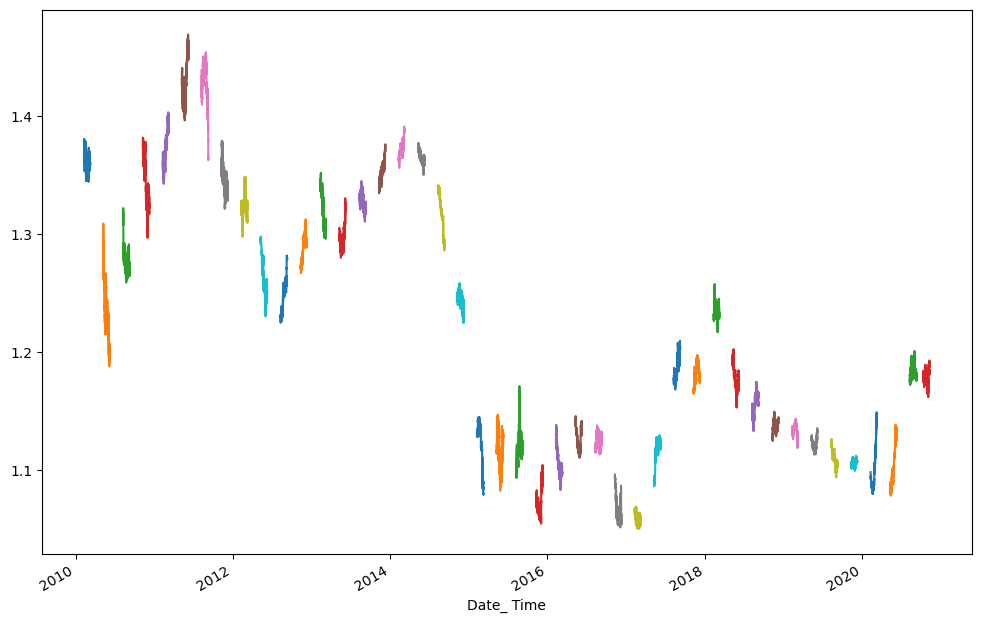

In [13]:
for p in getFileNames("E6"):
    getDf(p)[" Last"].plot()

In [8]:
es

,o,h,l,c,vol,nrT,bidVol,askVol,contract
date,,,,,,,,,
2010-02-10 00:00:00,1063.75,1063.75,1063.50,1063.75,46,0,0,0,E6H10
2010-02-10 00:01:00,1063.50,1063.50,1063.50,1063.50,9,0,0,0,E6H10
2010-02-10 00:02:00,1063.50,1063.75,1063.50,1063.50,81,0,0,0,E6H10
2010-02-10 00:03:00,1063.50,1063.50,1063.25,1063.50,65,0,0,0,E6H10
2010-02-10 00:04:00,1063.50,1063.50,1063.25,1063.50,18,0,0,0,E6H10
...,...,...,...,...,...,...,...,...,...
2020-11-09 23:55:00,3512.75,3513.50,3512.75,3513.50,194,169,90,104,E6Z20
2020-11-09 23:56:00,3513.50,3514.25,3512.75,3513.00,115,102,59,56,E6Z20
2020-11-09 23:57:00,3513.00,3513.75,3512.25,3513.75,126,118,52,74,E6Z20


In [9]:
def getGaps(series,cols={"contract":"contract","open":"o","close":"c"},backRoll=True):
    rollDates = series[cols["contract"]].drop_duplicates(keep="first").index
    gaps = series[cols["close"]]*0
    iloc = list(series.index)
    iloc = [iloc.index(i)-1 for i in rollDates]
    gaps.loc[rollDates[1:]] = series[cols["open"]].loc[rollDates[1:]] - series[cols["close"]].iloc[iloc[1:]].values
    gaps=gaps.cumsum()
    if backRoll: gaps-=gaps.iloc[-1]
    return gaps

def applyRolls(df,ohlc=["o","h","l","c"],cols={"contract":"contract","open":"o","close":"c"},backRoll=True):
    gaps=getGaps(df,cols,backRoll)
    for c in ohlc:df[c]-=gaps
    return df[ohlc]

def getNonNegRolledPrice(df,ohlc=["o","h","l","c"],cols={"contract":"contract","open":"o","close":"c"}):
    gaps=getGaps(df)
    gaps.plot(label="gaps")
    rolled = df[ohlc].copy(deep=True)
    for c in ohlc:rolled[c]-=gaps
    plt.plot(rolled["c"]-df["c"], label="rolled")
    plt.legend()
    rolled["returns"] = rolled[cols["close"]].diff()/df[cols["close"]].shift(1)
    return (1+rolled["returns"]).cumprod().rename("rPrices")

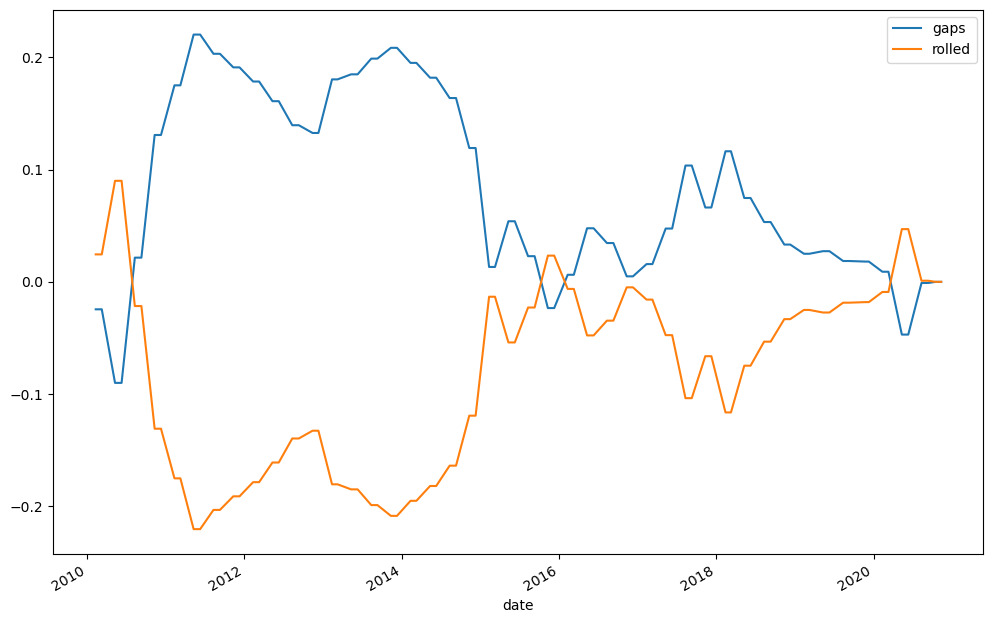

In [10]:
e6["rPrices"] = getNonNegRolledPrice(e6)

In [11]:
es["rPrices"] = getNonNegRolledPrice(es)

ValueError: operands could not be broadcast together with shapes (43,) (42,) 

In [11]:
future = "E6"
contFuture = os.path.join(workPath, future, f"{future}Cont")
e6.reset_index().to_feather(contFuture)